<a href="https://colab.research.google.com/github/pranmod01/perceptrons-neuromatch/blob/master/RNNtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# @title 1. Load  Features
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
PROJECT_PATH = "/content/drive/MyDrive/rnn_neuromatch"
DATA_PATH    = f"{PROJECT_PATH}/data"
NOTEBOOKS_PATH = f"{PROJECT_PATH}/notebooks"

In [7]:
!pip -q install torch torchvision torchmetrics rsatoolbox

import os, random, warnings, numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(42); np.random.seed(42); random.seed(42)
if torch.cuda.is_available(): torch.cuda.manual_seed(42)

Using device: cpu


In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_mnist_dataset(batch_size=128, data_dir='/content/data'):
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
    ])
    test_dataset = datasets.MNIST(root=data_dir, train=False, transform=transform, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return test_loader

test_loader = load_mnist_dataset()


In [9]:
# @title 2. Preprocess & Flatten MNIST Data { display-mode: "form" }

def preprocess_mnist(test_loader):
    """Flatten and reshape MNIST data to [batch_size, sequence_len, input_dim]"""
    X_all, y_all = [], []
    for images, labels in test_loader:
        batch_size = images.size(0)
        # Flatten spatial dimensions and treat them as sequence
        X_seq = images.view(batch_size, -1, 1).squeeze(-1)  # [B, 227*227]
        # Convert to sequence: [B, seq_len, input_dim] --> [B, 227, 227]
        X_seq = X_seq.view(batch_size, 227, 227)  # can change if needed
        X_all.append(X_seq)
        y_all.append(labels)

    X_all = torch.cat(X_all, dim=0)
    y_all = torch.cat(y_all, dim=0)

    print(f"Preprocessed X shape: {X_all.shape}")
    return X_all, y_all

X_mnist, y_mnist = preprocess_mnist(test_loader)


Preprocessed X shape: torch.Size([10000, 227, 227])


In [10]:
# @title 3. RNN Model Definition {display-mode: "form"}
class MemoryRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=10, rnn_type="RNN"):
        super().__init__()
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        else:
            self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x, return_seq=False):
        h_seq, _ = self.rnn(x)
        out = self.fc(self.dropout(h_seq[:, -1, :]))
        if return_seq:
            return out, h_seq
        return out


In [11]:
from torch.utils.data import Dataset

class MemoryDataset(Dataset):
    def __init__(self, X, y, noise=None, noise_std=0.05):
        self.X = X
        self.y = y
        self.noise = noise
        self.noise_std = noise_std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        if self.noise == "input":
            x = x + self.noise_std * torch.randn_like(x)

        return x, y


In [13]:
# @title 4. Training Function (clean / input‑noise / weight‑noise) {display-mode: "form"}
BATCH_SIZE = 128
MDS_DIM = X_mnist.shape[1]

def train_rnn(X, y, variant="clean", epochs=10, noise_std=0.05):
    ds = MemoryDataset(X, y, noise="input" if variant=="input_noise" else None,
                       noise_std=noise_std)
    dl = DataLoader(ds, BATCH_SIZE, shuffle=True, drop_last=True)

    model = MemoryRNN(MDS_DIM).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
    lossf = nn.CrossEntropyLoss()
    print(f" Training variant: {variant}")

    for ep in range(epochs):
        running = 0
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)

            # forward
            pred = model(xb)
            loss = lossf(pred, yb)

            # weight noise variant
            if variant == "weight_noise":
                for p in model.parameters():
                    p.data += noise_std * torch.randn_like(p)

            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item()
        print(f"  Epoch {ep+1}/{epochs} | loss={running/len(dl):.4f}")
    return model

model_clean       = train_rnn(X_mnist, y_mnist, "clean")
model_input_noise = train_rnn(X_mnist, y_mnist, "input_noise")
model_weight_noise= train_rnn(X_mnist, y_mnist, "weight_noise")



 Training variant: clean
  Epoch 1/10 | loss=2.0865
  Epoch 2/10 | loss=1.8758
  Epoch 3/10 | loss=1.7748
  Epoch 4/10 | loss=1.7586
  Epoch 5/10 | loss=1.7530
  Epoch 6/10 | loss=1.7513
  Epoch 7/10 | loss=1.7398
  Epoch 8/10 | loss=1.7411
  Epoch 9/10 | loss=1.7292
  Epoch 10/10 | loss=1.7288
 Training variant: input_noise
  Epoch 1/10 | loss=2.1519
  Epoch 2/10 | loss=1.8284
  Epoch 3/10 | loss=1.7851
  Epoch 4/10 | loss=1.7668
  Epoch 5/10 | loss=1.7527
  Epoch 6/10 | loss=1.7529
  Epoch 7/10 | loss=1.7408
  Epoch 8/10 | loss=1.7525
  Epoch 9/10 | loss=1.7401
  Epoch 10/10 | loss=1.7342
 Training variant: weight_noise
  Epoch 1/10 | loss=4.2886
  Epoch 2/10 | loss=nan
  Epoch 3/10 | loss=nan
  Epoch 4/10 | loss=nan
  Epoch 5/10 | loss=nan
  Epoch 6/10 | loss=nan
  Epoch 7/10 | loss=nan
  Epoch 8/10 | loss=nan
  Epoch 9/10 | loss=nan
  Epoch 10/10 | loss=nan


In [14]:
import os

DATA_PATH = "saved_data"
os.makedirs(DATA_PATH, exist_ok=True)


In [15]:
# @title 5. Save Hidden States & Weights {display-mode: "form"}
def save_hidden_states(model, X, y, tag):
    dl = DataLoader(MemoryDataset(X, y), BATCH_SIZE, shuffle=False)
    h_collect, lbl_collect = [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(device)
            _, h_seq = model(xb, return_seq=True)
            h_collect.append(h_seq[:, -1, :].cpu())
            lbl_collect.append(yb)
    hid = torch.cat(h_collect).numpy()
    lbl = torch.cat(lbl_collect).numpy()
    np.save(f"{DATA_PATH}/hidden_states_{tag}.npy", hid)
    np.save(f"{DATA_PATH}/labels_{tag}.npy", lbl)
    torch.save(model.state_dict(), f"{DATA_PATH}/rnn_{tag}_weights.pth")
    print(f"✅ Saved arrays for {tag}")
save_hidden_states(model_clean, X_mnist, y_mnist, "rnn_mnist_clean")
save_hidden_states(model_input_noise, X_mnist, y_mnist, "rnn_mnist_inoise")
save_hidden_states(model_weight_noise, X_mnist, y_mnist, "rnn_mnist_wnoise")



✅ Saved arrays for rnn_mnist_clean
✅ Saved arrays for rnn_mnist_inoise
✅ Saved arrays for rnn_mnist_wnoise


In [16]:
import os
print(os.listdir("saved_data"))


['rnn_rnn_mnist_wnoise_weights.pth', 'hidden_states_rnn_mnist_inoise.npy', 'labels_rnn_mnist_clean.npy', 'labels_rnn_mnist_inoise.npy', 'hidden_states_rnn_mnist_clean.npy', 'rnn_rnn_mnist_inoise_weights.pth', 'labels_rnn_mnist_wnoise.npy', 'rnn_rnn_mnist_clean_weights.pth', 'hidden_states_rnn_mnist_wnoise.npy']


In [17]:
import numpy as np

DATA_PATH = "saved_data"

hid = np.load(f"{DATA_PATH}/hidden_states_rnn_mnist_clean.npy")  # shape: [num_samples, hidden_dim]
lbl = np.load(f"{DATA_PATH}/labels_rnn_mnist_clean.npy")         # shape: [num_samples]


In [18]:
print("hid shape:", hid.shape)   # should be [N, hidden_dim]
print("lbl shape:", lbl.shape)   # should be [N]


hid shape: (10000, 64)
lbl shape: (10000,)


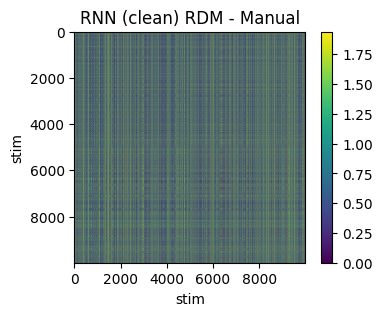

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Load and align data (same as before)
DATA_PATH = "saved_data"
hid = np.load(f"{DATA_PATH}/hidden_states_rnn_mnist_clean.npy")
lbl = np.load(f"{DATA_PATH}/labels_rnn_mnist_clean.npy")

# Align lengths
min_len = min(hid.shape[0], lbl.shape[0])
hid = hid[:min_len]
lbl = lbl[:min_len]

# Convert labels to strings
lbl = [str(x) for x in lbl]

# Compute RDM using 1 - Pearson correlation
rdm_matrix = squareform(pdist(hid, metric='correlation'))  # shape: (N, N)

# Plot RDM
plt.figure(figsize=(4, 3))
plt.imshow(rdm_matrix, cmap='viridis')
plt.colorbar()
plt.title("RNN (clean) RDM - Manual")
plt.xlabel("stim")
plt.ylabel("stim")
plt.show()


In [23]:
# @title 7. Accuracy on Training Set (fast sanity) {display-mode: "form"}
def accuracy(model, X, y):
    dl = DataLoader(MemoryDataset(X, y), BATCH_SIZE)
    correct=total=0
    with torch.no_grad():
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            _, pred = torch.max(logits, 1)
            total += len(yb); correct += (pred==yb).sum().item()
    return correct/total

for name, mdl in zip(["clean", "input_noise", "weight_noise"],
                     [model_clean, model_input_noise, model_weight_noise]):
    print(f"{name:12s} acc = {accuracy(mdl, X_mnist, y_mnist)*100:.2f}%")



clean        acc = 33.91%
input_noise  acc = 33.89%
weight_noise acc = 9.80%


In [26]:
import os

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    for file in files:
        if file == "RNNtest.ipynb":
            print(os.path.join(root, file))


/content/drive/MyDrive/rnn_neuromatch/perceptrons-neuromatch/RNNtest.ipynb
